In [1]:
# Don't forget to execute this cell
import os 
import bionetgen as pybng
import matplotlib.pyplot as plt
import numpy as np 
workdir = os.path.abspath(os.getcwd())

# Model parsing

PyBNG also comes with basic BNGL parsing capabilities. This method of parsing involves generating an intermediary file so it has a small overhead due to the file I/O. We are working on a much better parsing solution using C++ and that will become the default way to parse models in the future. This creates a simple model object that allows some basic programmatic manipulation of the model.

In [2]:
# let's load the model same model we have been running
model = pybng.bngmodel("SIR.bngl")

BioNetGen version 2.8.3
Reading from file /tmp/tmp9kabe_0d/SIR.bngl (level 0)
Read 4 parameters.
Read 3 molecule types.
Read 3 species.
Read 3 observable(s).
Read 2 reaction rule(s).
Wrote model in xml format to ./SIR.xml.
Finished processing file /tmp/tmp9kabe_0d/SIR.bngl.
CPU TIME: total 0.03 s.


This model object is written with BNGL in mind, so printing the model or individual blocks will give you the BNGL representation of that portion of the model.

In [3]:
print(model) # this will print the entire model

print(model.parameters) # this will print the parameters block

begin model

begin parameters
  N 100
  I0 1
  b 0.018
  g 1
end parameters

begin molecule types
  I()
  R()
  S()
end molecule types

begin species
  S() 99
  I() 1
  R() 0
end species

begin observables
  Molecules S S()
  Molecules I I()
  Molecules R R()
end observables

begin reaction rules
  R1: S() + I() -> I() + I() b 
  R2: I() -> R() g 
end reaction rules

end model

generate_network({overwrite=>1})
simulate({method=>"ode",t_end=>50,n_steps=>1000})

begin parameters
  N 100
  I0 1
  b 0.018
  g 1
end parameters



The model is also written with python in mind and the objects behave in a pythonic manner whenever possible. For more information, please check the model documentation [here](https://pybionetgen.readthedocs.io/en/latest/bngmodel.html)

In [4]:
for block in model:
    print(block.name)
    if block.name == "parameters":
        print(f"Looping over block: {block.name}")
        for param in block:
            print(f"parameter name: {param}, value: {model.parameters[param]}")
    elif block.name == "observables": 
        print(f"Looping over block: {block.name}")
        for obs in block:
            o = block[obs]
            print(f"observable name: {o.name}, patterns: {o.patterns}, type: {o.type}")

parameters
Looping over block: parameters
parameter name: N, value: N 100
parameter name: I0, value: I0 1
parameter name: b, value: b 0.018
parameter name: g, value: g 1
molecule types
species
observables
Looping over block: observables
observable name: S, patterns: [S()], type: Molecules
observable name: I, patterns: [I()], type: Molecules
observable name: R, patterns: [R()], type: Molecules
reaction rules
actions


### Running the model object directly

You can run the model object directly. This returns a BNGResult object which we will talk about next. 

In [5]:
result = pybng.run(model, suppress=True)

In [6]:
print(result)

gdats from 1 models: SIR 
cdats from 1 models: SIR 


### Results object

This object will read all `gdat/cdat/scan` files that it finds in the folder where the model was ran and read it into `numpy record arrays`. You can access the `gdat` files by directly indexing the results object with 

```
results[0]
```

or you can access individual objects using `gdats/cdats/scans` attributes

```
results.gdats['model_name'][0]
results.cdats['model_name'][0]
results.scans['model_name'][0]
```

you can print the results object to see what's stored in side with `print(results)`. 

In [7]:
print("This is the results object:")
print(result) # this gives you a summary of what's stored in the object
print("            --             ")
print("First gdat record array:")
print(result.gdats["SIR"][:2]) # you can look at gdats file via the gdats attribute
print("            --             ")
print("Also the first gdat record array:")
print(result[0][:2]) # or by indexing which defaults to loaded gdat files
print("            --             ")
print("First cdat record array:")
print(result.cdats["SIR"][:2]) # for other types of files you need to manually select the correct attribute
print("            --             ")

This is the results object:
gdats from 1 models: SIR 
cdats from 1 models: SIR 
            --             
First gdat record array:
[(0.  , 99.        , 1.        , 0.        )
 (0.05, 98.90917811, 1.03983223, 0.05098966)]
            --             
Also the first gdat record array:
[(0.  , 99.        , 1.        , 0.        )
 (0.05, 98.90917811, 1.03983223, 0.05098966)]
            --             
First cdat record array:
[(0.  , 99.        , 1.        , 0.        )
 (0.05, 98.90917811, 1.03983223, 0.05098966)]
            --             


You can index these record arrays with observable names. This allows for quick plotting of results or doing analysis on the time series generated by BNG. 

Let's plot each time series that is loaded in. 

('time', 'S', 'I', 'R')


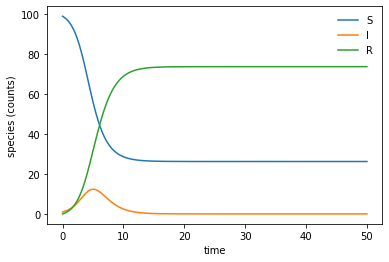

In [8]:
# let's pull the first gdat file
r = result[0] # let's get the gdat record array
print(r.dtype.names) # this will print the names of the observables you can select
# now we can loop over each observable name and plot them
for name in r.dtype.names:
    # we don't want to plot time
    if name != "time":
        # plot the observable values over time
        plt.plot(r['time'], r[name], label=name)
# label everything
plt.xlabel("time")
plt.ylabel("species (counts)")
_ = plt.legend(frameon=False)

Simple manipulations of the model object is possible, particularly static values (e.g. parameter values, compartment sizes, initial species counts). This allows for some simple analyses that can be done using this API. 

Please note that this is a fairly inefficient implementation for complicated analyses since this process reads and writes files which doesn't scale well for larger number of simulations. We will talk more about more efficient ways to implement analyses at the end of this section as well as in the advanced topics lesson.

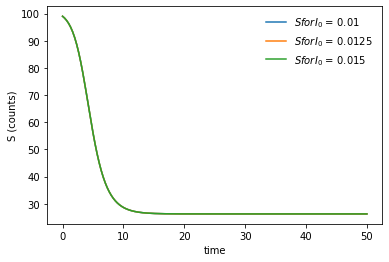

In [9]:
# change stuff here
parameter_to_change = "b"
observable_to_plot = "S"

# don't touch here
model.actions.clear_actions()
model.add_action("simulate", action_args={"method":'"ode"',"t_end":50,"n_steps":300})
for i in [0.01,0.0125,0.015]:
    model.parameters[parameter_to_change].expr = i
    # run can also take a model object as an argument
    # you can also suppress BNG output by using the keyword argument "suppress"
    result = pybng.run(model, suppress=True)
    plt.plot(result[0]['time'], result[0][observable_to_plot], label=f"${observable_to_plot} for I_{0}$ = "+f"{i}")
_ = plt.xlabel("time")
_ = plt.ylabel(f"{observable_to_plot} (counts)")
_ = plt.legend(frameon=False)

PyBNG also allows for programmatically working with different sections of the model. Let's load in a more complicated model and see how it works.

In [10]:
egfr = pybng.bngmodel("egfr_simple.bngl")
print(egfr.rules)

BioNetGen version 2.8.3
Reading from file /tmp/tmp_goxekdu/egfr_simple.bngl (level 0)
Read 19 parameters.
Read 4 molecule types.
Read 4 species.
Read 6 observable(s).
Read 7 reaction rule(s).
Wrote model in xml format to ./egfr_simple.xml.
Finished processing file /tmp/tmp_goxekdu/egfr_simple.bngl.
CPU TIME: total 0.05 s.

begin reaction rules
  lrbind: EGFR(L,CR1) + EGF(R) <-> EGFR(L!1,CR1).EGF(R!1) kp1,km1 
  rdim: EGFR(L!+,CR1) + EGFR(L!+,CR1) <-> EGFR(L!+,CR1!1).EGFR(L!+,CR1!1) kp2,km2 
  tphos: EGFR(CR1!+,Y1068~U) -> EGFR(CR1!+,Y1068~P) kp3 
  dephos: EGFR(Y1068~P) -> EGFR(Y1068~U) km3 
  egfr_grb2: EGFR(Y1068~P) + Grb2(SH2) <-> EGFR(Y1068~P!1).Grb2(SH2!1) kp4,km4 
  grb2_sos1: Grb2(SH3) + Sos1(PxxP) <-> Grb2(SH3!1).Sos1(PxxP!1) kp5,km5 
  rint: EGF(R!1).EGF(R!2).EGFR(L!1,CR1!3).EGFR(L!2,CR1!3) -> 0 deg 
end reaction rules



For example PyBNG allows you to loop over everything included in a rule and each pattern

In [11]:
for rule in egfr.rules:
    r = egfr.rules[rule]
    print("####")
    print(f"Rule: {r}")
    reactants = r.reactants
    products = r.products
    print("  Reactants:")
    for reactant in reactants:
        print(f"    Reactant: {reactant}")
        for molecule in reactant:
            print(f"      Molecule: {molecule}, name: {molecule.name}")
            for component in molecule:
                print(f"        Component: {component}, name: {component.name}, state: {component.state}")
    print("  Products:")
    for product in products:
        print(f"    Product: {reactant}")
        for molecule in reactant:
            print(f"      Molecule: {molecule}, name: {molecule.name}")
            for component in molecule:
                print(f"        Component: {component}, name: {component.name}, state: {component.state}")
print("####")

####
Rule: lrbind: EGFR(L,CR1) + EGF(R) <-> EGFR(L!1,CR1).EGF(R!1) kp1,km1 
  Reactants:
    Reactant: EGFR(L,CR1)
      Molecule: EGFR(L,CR1), name: EGFR
        Component: L, name: L, state: None
        Component: CR1, name: CR1, state: None
    Reactant: EGF(R)
      Molecule: EGF(R), name: EGF
        Component: R, name: R, state: None
  Products:
    Product: EGF(R)
      Molecule: EGF(R), name: EGF
        Component: R, name: R, state: None
####
Rule: rdim: EGFR(L!+,CR1) + EGFR(L!+,CR1) <-> EGFR(L!+,CR1!1).EGFR(L!+,CR1!1) kp2,km2 
  Reactants:
    Reactant: EGFR(L!+,CR1)
      Molecule: EGFR(L!+,CR1), name: EGFR
        Component: L!+, name: L, state: None
        Component: CR1, name: CR1, state: None
    Reactant: EGFR(L!+,CR1)
      Molecule: EGFR(L!+,CR1), name: EGFR
        Component: L!+, name: L, state: None
        Component: CR1, name: CR1, state: None
  Products:
    Product: EGFR(L!+,CR1)
      Molecule: EGFR(L!+,CR1), name: EGFR
        Component: L!+, name: L, state

### Using BNGResult to load in gdat/cdat/scan files

We can also use the result object to load in multiple gdat/cdat/scan files at the same time

In [12]:
from bionetgen.core.tools import BNGResult
all_results = BNGResult("data/.")
print(all_results)

gdats from 3 models: egfr_simple_ssa egfr_simple_nf egfr_simple_ode 
cdats from 2 models: egfr_simple_ssa egfr_simple_ode 


('time', 'Sos1_act', 'EGFR_tot', 'Lig_free', 'Dim', 'RP', 'Grb2Sos1')
('time', 'Sos1_act', 'EGFR_tot', 'Lig_free', 'Dim', 'RP', 'Grb2Sos1')
('time', 'Sos1_act', 'EGFR_tot', 'Lig_free', 'Dim', 'RP', 'Grb2Sos1')


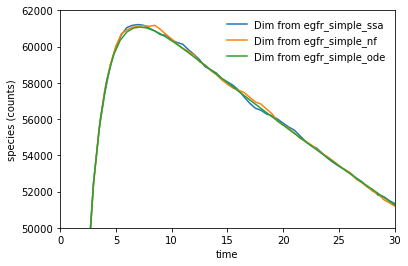

In [13]:
observable_to_plot = "Dim"
# loop over all gdat files
for gname in all_results.gnames:
    r = all_results.gdats[gname]
    print(r.dtype.names) # this will print the names of the observables you can select
    # plot a single series
    plt.plot(r['time'][:100], r[observable_to_plot][:100], label=f"{observable_to_plot} from {gname}")
    # now we can loop over each observable name and plot them
    # for name in r.dtype.names:
    #     # we don't want to plot time
    #     if name != "time":
    #         # plot the observable values over time
    #         plt.plot(r['time'], r[name], label=name)
    # break
# label everything
plt.ylim((5.e4,6.2e4))
plt.xlim((0,30))
plt.xlabel("time")
plt.ylabel("species (counts)")
_ = plt.legend(frameon=False)

### Alternative compiled simulator

BioNetGen version 2.8.3
Reading from file /tmp/tmptlc8h95y/SIR.bngl (level 0)
Read 4 parameters.
Read 3 molecule types.
Read 3 species.
Read 3 observable(s).
Read 2 reaction rule(s).
Wrote model in xml format to ./SIR.xml.
Finished processing file /tmp/tmptlc8h95y/SIR.bngl.
CPU TIME: total 0.03 s.


BioNetGen version 2.8.3
Reading from file /tmp/tmpni8ym_0h/SIR_cpy.bngl (level 0)
Read 4 parameters.
Read 3 molecule types.
Read 3 species.
Read 3 observable(s).
Read 2 reaction rule(s).
ACTION: generate_network( SIR_cpy )
Iteration   0:     3 species      0 rxns  0.00e+00 CPU s
Iteration   1:     3 species      2 rxns  2.00e-02 CPU s
Cumulative CPU time for each rule
Rule   1:     1 reactions 2.00e-02 CPU s 2.00e-02 CPU s/rxn
Rule   2:     1 reactions 0.00e+00 CPU s 0.00e+00 CPU s/rxn
Total   :     2 reactions 2.00e-02 CPU s 1.00e-02 CPU s/rxn
Wrote network in net format to ./SIR_cpy.net.
CPU TIME: generate_network 0.02 s.
Wrote model in xml format to ./SIR_cpy.xml.
Finished processing file /tmp/tmpni8ym_0h/SIR_cpy.bngl.
CPU TIME: total 0.03 s.
BioNetGen version 2.8.3
Reading from file /home/boltzmann/workshop_temp_folder/Workshop_2022/bionetgen/PyBNG/advanced_session/SIR_cpy.bngl (level 0)
Read 4 parameters.
Read 3 molecule types.
Read 3 species.
Read 3 observable(s).
Read 2 reaction

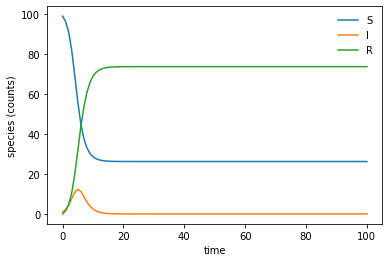

In [14]:
os.chdir(workdir)
SIR = pybng.bngmodel("SIR.bngl")
csim_SIR = SIR.setup_simulator(sim_type="cpy")

print(csim_SIR.model.parameters)
# csim_SIR.model.parameters.b = 0.02
# csim_SIR.model.parameters.g = 0.5
time, observables, species = csim_SIR.simulate(0,100,100)
for name in observables.dtype.names:
    # we don't want to plot time
    if name != "time":
        # plot the observable values over time
        plt.plot(time, observables[name], label=name)
# label everything
plt.xlabel("time")
plt.ylabel("species (counts)")
_ = plt.legend(frameon=False)

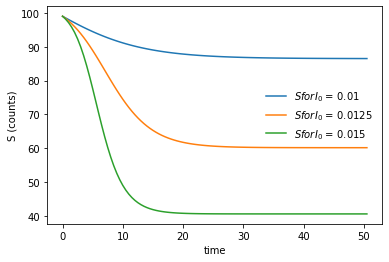

In [15]:
parameter_to_change = "b"
observable_to_plot = "S"
for i in [0.01,0.0125,0.015]:
    csim_SIR.model.parameters[parameter_to_change].expr = i
    # run can also take a model object as an argument
    # you can also suppress BNG output by using the keyword argument "suppress"
    time, obs, spc = csim_SIR.simulate(0,50,100)
    plt.plot(time,obs[observable_to_plot], label=f"${observable_to_plot} for I_{0}$ = "+f"{i}")
_ = plt.xlabel("time")
_ = plt.ylabel(f"{observable_to_plot} (counts)")
_ = plt.legend(frameon=False)

### Pattern parsing

PyBNG also has basic pattern parsing from strings. This can come in handy when working with the species file or if you want to get the pattern as an object. 

In [16]:
from bionetgen.modelapi.pattern_reader import BNGPatternReader

# the testing file
species_file = os.path.join("data", "egfr_simple_nf.species")
with open(species_file, "r+") as f:
    species = f.readlines()
# loop over species
patterns = []
res = True
for ipat, pat in enumerate(species):
    if pat.startswith("#"):
        continue
    pat_splt = pat.split("    ")
    pat = pat_splt[0]
    pat_obj = BNGPatternReader(pat).pattern
    patterns.append(pat_obj)

print(patterns)

[EGF(R!1).EGFR(L!1,CR1!2,Y1068~P!3).EGFR(L!4,CR1!2,Y1068~P!5).Grb2(SH2!3,SH3!6).EGF(R!4).Grb2(SH2!5,SH3!7).Sos1(PxxP!6).Sos1(PxxP!7), EGF(R!1).EGFR(L!1,CR1!2,Y1068~P!3).EGFR(L!4,CR1!2,Y1068~P!5).Grb2(SH2!3,SH3!6).EGF(R!4).Grb2(SH2!5,SH3).Sos1(PxxP!6), EGF(R!1).EGFR(L!1,CR1!2,Y1068~P!3).EGFR(L!4,CR1!2,Y1068~P!5).Grb2(SH2!3,SH3).EGF(R!4).Grb2(SH2!5,SH3!6).Sos1(PxxP!6), EGF(R!1).EGFR(L!1,CR1!2,Y1068~P!3).EGFR(L!4,CR1!2,Y1068~P!5).Grb2(SH2!3,SH3).EGF(R!4).Grb2(SH2!5,SH3), EGF(R!1).EGFR(L!1,CR1!2,Y1068~P!3).EGFR(L!4,CR1!2,Y1068~P).Grb2(SH2!3,SH3!5).EGF(R!4).Sos1(PxxP!5), EGF(R!1).EGFR(L!1,CR1!2,Y1068~P!3).EGFR(L!4,CR1!2,Y1068~P).Grb2(SH2!3,SH3).EGF(R!4), EGF(R!1).EGFR(L!1,CR1!2,Y1068~P!3).EGFR(L!4,CR1!2,Y1068~U).Grb2(SH2!3,SH3!5).EGF(R!4).Sos1(PxxP!5), EGF(R!1).EGFR(L!1,CR1!2,Y1068~P!3).EGFR(L!4,CR1!2,Y1068~U).Grb2(SH2!3,SH3).EGF(R!4), EGF(R!1).EGFR(L!1,CR1!2,Y1068~P).EGFR(L!3,CR1!2,Y1068~P!4).EGF(R!3).Grb2(SH2!4,SH3!5).Sos1(PxxP!5), EGF(R!1).EGFR(L!1,CR1!2,Y1068~P).EGFR(L!3,CR1!2,Y1068~P!4